In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import WeibullAFTFitter as wf_aft
from lifelines import LogNormalAFTFitter as lnf_aft
from lifelines import LogLogisticAFTFitter as llf_aftcl

In [4]:
df = pd.read_csv('telco.csv')
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


In [5]:
#changing churn into binary values
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

In [6]:
#encoding categorical variables and turning them into dummies
encode_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']

In [7]:
survival_df = pd.get_dummies(df, columns=encode_cols, prefix=encode_cols, drop_first=True)

In [8]:
#The models only work for positive values, so we need to change the zeros in tenure column.
survival_df["tenure"] = np.where(survival_df["tenure"] == 0, 0.0000001, survival_df["tenure"])
survival_df.head()

,ID,tenure,age,address,income,churn,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,...,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service
0,1,13.0,44,9,64,1,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,2,11.0,33,7,136,1,False,True,False,False,...,True,False,False,True,True,False,True,False,False,True
2,3,68.0,52,24,116,0,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
3,4,33.0,33,12,33,1,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,5,23.0,30,9,30,0,True,False,False,True,...,False,False,False,True,False,False,True,False,True,False


AFT models

Model: WeibullAFTFitter
                                             coef  exp(coef)  se(coef)  \
param   covariate                                                        
lambda_ ID                              -0.000514   0.999486  0.000182   
        address                          0.041965   1.042858  0.008765   
        age                              0.028338   1.028743  0.006734   
        custcat_E-service                0.981685   2.668950  0.154014   
        custcat_Plus service             0.735620   2.086776  0.192220   
        custcat_Total service            0.962885   2.619243  0.212317   
        ed_Did not complete high school  0.463497   1.589623  0.193139   
        ed_High school degree            0.294820   1.342885  0.144773   
        ed_Post-undergraduate degree     0.176300   1.192796  0.189922   
        ed_Some college                  0.252504   1.287245  0.143347   
        forward_Yes                     -0.089337   0.914537  0.148469   
        gender

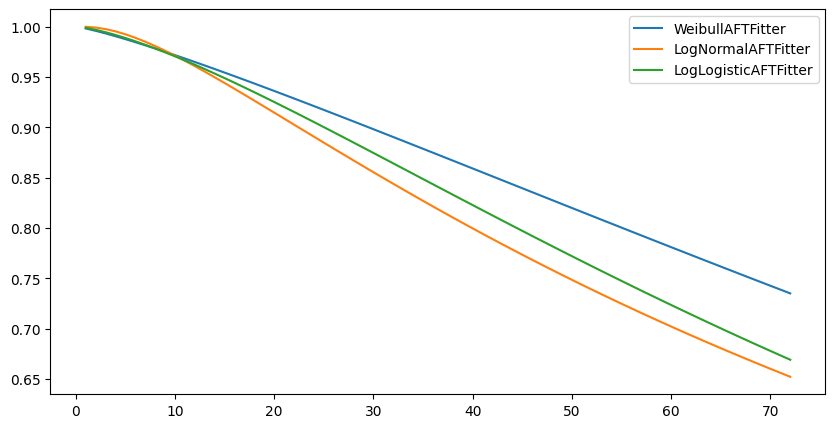

In [10]:
wf = wf_aft()
lnf = lnf_aft()
llf = llf_aftcl()

fig, ax = plt.subplots(figsize=(10, 5))

list_labels = ["WeibullAFTFitter", "LogNormalAFTFitter", "LogLogisticAFTFitter"]
i = 0

for model in [wf, lnf, llf]:
    try:
        model.fit(survival_df, duration_col="tenure", event_col="churn")
        
        # Print summary
        print(f"Model: {list_labels[i]}")
        print(model.summary)
        print("")

        plt.plot(model.predict_survival_function(survival_df.loc[1]), label=list_labels[i])
        i += 1
    except Exception as e:
        print(f"Caught an error: {e}")
        pass

plt.legend()
plt.show()

Weibull AFT Model:
    lambda_ ID has a negative coefficient, suggesting that the baseline hazard decreases with ID.
    The rho_ coefficient represents the shape parameter of the Weibull distribution. A positive coefficient suggests increasing hazard over time

Log-Normal AFT Model: 
    positive coefficients indicate an increase in the location parameter, implying higher hazard.
    sigma_ (Scale Parameter): Represents the standard deviation of the log-normal distribution. A higher value suggests higher variability in survival times.

Log-Logistic AFT Model: 
    alpha_ (Shape Parameter): Positive coefficient implies increasing hazard over time, while a negative coefficient suggests decreasing hazard.
    beta_ (Scale Parameter): Reflects the degree of variability in survival times.

1. "custcat_E-service, custcat_Plus service, and custcat_Total service" have significant positive coefficients in all models, suggesting higher hazard for these customer categories.

2. "income" has a small but positive coefficient in Weibull and log-normal models, indicating a slight increase in hazard with income.

3. From the plot, the LogNormal model has the lowest AIC and BIC, and the highest log-likelihood value. Meaning that the model fits better than the others to our data. So we choose LogNormal model as our AFT Fitter.

4. The significant features are: address, age, custcat_E-service, custcat_Plus service, custcat_Total service, internet_Yes, marital_Unmarried, voice_Yes according to their p-values

Coefficients:
                                            coef  exp(coef)  se(coef)  \
param  covariate                                                        
mu_    ID                              -0.000474   0.999526  0.000198   
       address                          0.042630   1.043551  0.008880   
       age                              0.033230   1.033788  0.007241   
       custcat_E-service                1.064673   2.899891  0.169648   
       custcat_Plus service             0.937889   2.554584  0.215175   
       custcat_Total service            1.210374   3.354739  0.249688   
       ed_Did not complete high school  0.376412   1.457047  0.200659   
       ed_High school degree            0.306672   1.358895  0.162321   
       ed_Post-undergraduate degree    -0.053980   0.947451  0.222322   
       ed_Some college                  0.285017   1.329785  0.164680   
       forward_Yes                     -0.203822   0.815608  0.179371   
       gender_Male                   

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

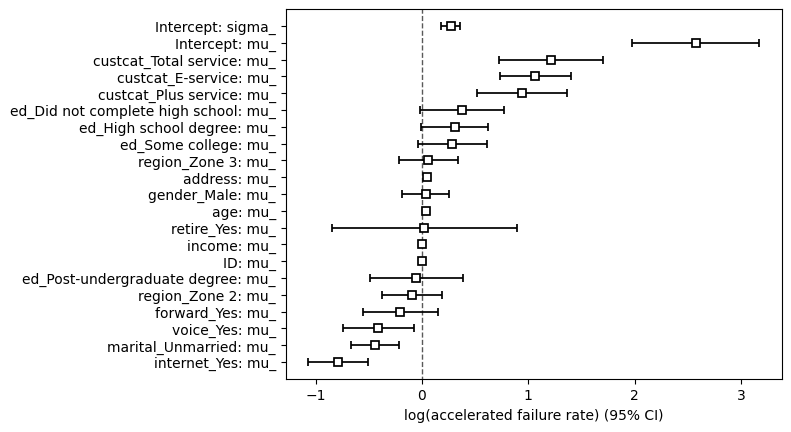

In [11]:
logn = lnf_aft()
logn.fit(survival_df, duration_col='tenure', event_col='churn')

summary_df = logn.summary
coefficients = summary_df[['coef', 'exp(coef)', 'se(coef)', 'coef lower 95%', 'coef upper 95%']]

print("Coefficients:")
print(coefficients)

logn.plot()

Calculating CLV

In [12]:
pred = logn.predict_survival_function(survival_df)
pred

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1.0,0.999400,0.999872,1.000000,0.998846,0.999941,0.999981,0.999013,0.997394,0.999996,0.999999,...,0.999645,0.999930,0.999547,1.000000,0.999379,0.994540,0.985134,1.000000,0.999897,0.999437
2.0,0.996630,0.999120,0.999999,0.994103,0.999551,0.999838,0.994837,0.988223,0.999963,0.999993,...,0.997860,0.999480,0.997358,0.999996,0.996529,0.978097,0.949949,0.999994,0.999267,0.996813
3.0,0.991798,0.997586,0.999994,0.986399,0.998699,0.999492,0.987937,0.974692,0.999870,0.999974,...,0.994569,0.998511,0.993423,0.999985,0.991576,0.956026,0.909020,0.999976,0.997959,0.992203
4.0,0.985377,0.995320,0.999985,0.976646,0.997378,0.998916,0.979096,0.958633,0.999701,0.999935,...,0.990028,0.997024,0.988087,0.999961,0.985009,0.931446,0.867589,0.999940,0.996001,0.986047
5.0,0.977771,0.992413,0.999969,0.965509,0.995619,0.998110,0.968912,0.941168,0.999448,0.999873,...,0.984498,0.995060,0.981670,0.999922,0.977246,0.905956,0.827587,0.999881,0.993463,0.978730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.0,0.506662,0.668271,0.977858,0.430731,0.735051,0.816702,0.449068,0.334179,0.897873,0.952007,...,0.565121,0.721377,0.538429,0.963098,0.502741,0.249267,0.147232,0.953740,0.687466,0.514022
69.0,0.502215,0.664215,0.977264,0.426355,0.731387,0.813728,0.444660,0.330131,0.895873,0.950884,...,0.560729,0.717621,0.534000,0.962190,0.498294,0.245743,0.144680,0.952649,0.683508,0.509577
70.0,0.497832,0.660200,0.976664,0.422051,0.727752,0.810768,0.440323,0.326161,0.893873,0.949757,...,0.556393,0.713896,0.529631,0.961276,0.493911,0.242297,0.142194,0.951554,0.679587,0.505194
71.0,0.493511,0.656223,0.976060,0.417817,0.724144,0.807822,0.436054,0.322267,0.891875,0.948626,...,0.552112,0.710201,0.525320,0.960359,0.489591,0.238925,0.139772,0.950455,0.675702,0.500873


In [13]:
#24 months
pred = pred.loc[1:12, :]
pred = pred.T
pred

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0.999400,0.996630,0.991798,0.985377,0.977771,0.969295,0.960184,0.950616,0.940729,0.930625,0.920388,0.910079
1,0.999872,0.999120,0.997586,0.995320,0.992413,0.988960,0.985044,0.980741,0.976112,0.971212,0.966085,0.960770
2,1.000000,0.999999,0.999994,0.999985,0.999969,0.999945,0.999911,0.999867,0.999811,0.999745,0.999666,0.999575
3,0.998846,0.994103,0.986399,0.976646,0.965509,0.953455,0.940810,0.927806,0.914610,0.901344,0.888097,0.874934
4,0.999941,0.999551,0.998699,0.997378,0.995619,0.993468,0.990968,0.988161,0.985087,0.981777,0.978264,0.974573
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.994540,0.978097,0.956026,0.931446,0.905956,0.880409,0.855274,0.830807,0.807144,0.784349,0.762444,0.741425
996,0.985134,0.949949,0.909020,0.867589,0.827587,0.789721,0.754193,0.720988,0.689996,0.661070,0.634053,0.608789
997,1.000000,0.999994,0.999976,0.999940,0.999881,0.999797,0.999685,0.999544,0.999373,0.999172,0.998941,0.998680
998,0.999897,0.999267,0.997959,0.996001,0.993463,0.990423,0.986953,0.983116,0.978969,0.974557,0.969923,0.965101


In [14]:
r = 12
monthly_margin = 1300

for col in range(0, len(pred.columns)):
    for row in range(0, 13):
        pred[col + 1][row + 1] = pred[col + 1][row + 1] / (1 + r / 12)**(row)

df['CLV'] = monthly_margin * pred.sum(axis = 0)
df.head(10)

/var/folders/80/8q3bm_q170q3t3446xcbxwjr0000gn/T/ipykernel_22481/4022081964.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pred[col + 1][row + 1] = pred[col + 1][row + 1] / (1 + r / 12)**(row)


,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn,CLV
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,1,NaN
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,1,1.281992e+06
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,0,1.272879e+06
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,1,1.261276e+06
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,0,1.248478e+06
5,6,Zone 2,41,39,Unmarried,17,78,High school degree,No,Female,No,No,No,Plus service,0,1.235127e+06
6,7,Zone 3,45,22,Married,2,19,High school degree,No,Female,No,Yes,No,E-service,1,1.221572e+06
7,8,Zone 2,38,35,Unmarried,5,76,High school degree,No,Male,Yes,Yes,Yes,Total service,0,1.208017e+06
8,9,Zone 3,45,59,Married,7,166,College degree,No,Male,No,No,Yes,Plus service,0,1.194583e+06
9,10,Zone 1,68,41,Married,21,72,Did not complete high school,No,Male,No,No,No,E-service,0,1.181344e+06


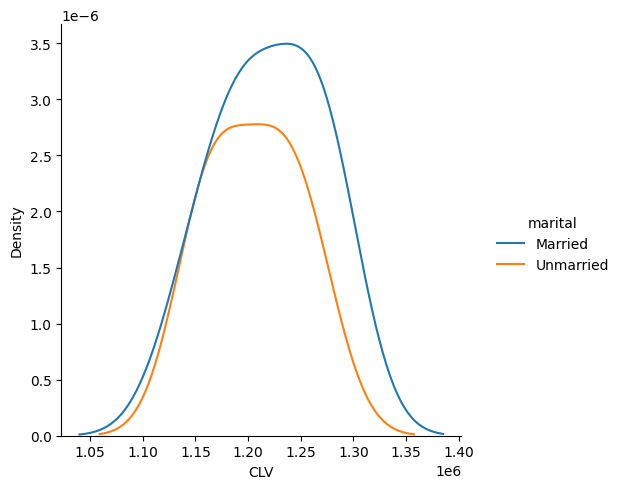

In [15]:
clv = sns.displot(df, x = 'CLV', kind = 'kde', hue = 'marital')

Unmarried customers are more likely to survive based on this plot.

/var/folders/80/8q3bm_q170q3t3446xcbxwjr0000gn/T/ipykernel_22481/3822920750.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  clv = sns.displot(df, x = 'CLV', kind = 'kde', hue = 'ed')


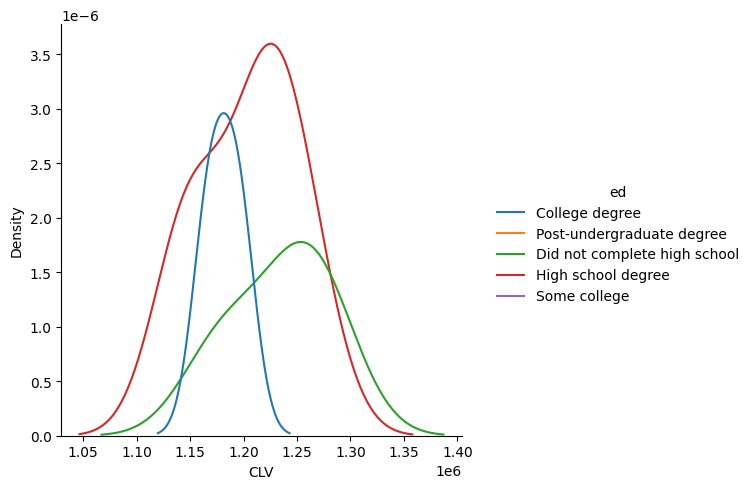

In [16]:
clv = sns.displot(df, x = 'CLV', kind = 'kde', hue = 'ed')

Customers without a high school diploma are more likely survive based on the plot.

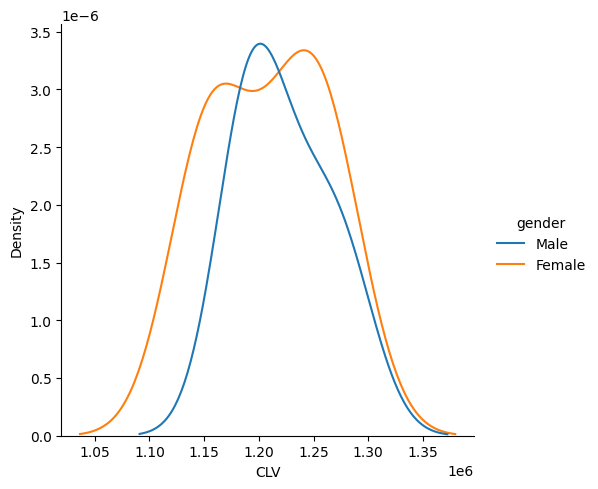

In [17]:
clv = sns.displot(df, x = 'CLV', kind = 'kde', hue = 'gender')

Female customers are more likely to survive.